# Step function

DGP papers have often demonstrated a step function, as this cannot be well captured by GP with a stationary kernel. We'll do that here also

In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

from gpflow.likelihoods import Gaussian
from gpflow.kernels import RBF, White
from gpflow.models.gpr import GPR
from gpflow.training import AdamOptimizer, ScipyOptimizer

from doubly_stochastic_dgp.dgp import DGP

np.random.seed(0)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -18.388479
  Number of iterations: 12
  Number of functions evaluations: 20


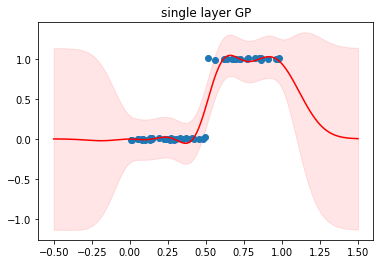

In [4]:
Ns = 300
Xs = np.linspace(-0.5, 1.5, Ns)[:, None]

N, M = 50, 25
X = np.random.uniform(0, 1, N)[:, None]
Z = np.random.uniform(0, 1, M)[:, None]
f_step = lambda x: 0. if x<0.5 else 1.
Y = np.reshape([f_step(x) for x in X], X.shape) + np.random.randn(*X.shape)*1e-2

def train_and_plot_gp(X, Y, kernel):
    m_gp = GPR(X, Y, kernel)
    ScipyOptimizer().minimize(m_gp)
    m, v = m_gp.predict_y(Xs)
    plt.plot(Xs, m, color='r')
    l = (m - 2*v**0.5).flatten()
    u = (m + 2*v**0.5).flatten()
    plt.fill_between(Xs.flatten(), l, u, color='r', alpha=0.1)
    plt.title('single layer GP')
    plt.scatter(X, Y)
    plt.show()
    
train_and_plot_gp(X, Y, RBF(1, lengthscales=0.2))

We'll now use a 2 layer DGP

In [6]:
def make_DGP(L):
    kernels = []
    for l in range(L):
        k = RBF(1, lengthscales=0.2, variance=1.) + White(1, variance=1e-5)
        kernels.append(k)

    m_dgp = DGP(X, Y, Z, kernels, Gaussian(), num_samples=100)
    
    # init the layers to near determinisic 
    for layer in m_dgp.layers[:-1]:
        layer.q_sqrt = layer.q_sqrt.value * 1e-5
    return m_dgp

m_dgp_2 = make_DGP(2)
AdamOptimizer(0.01).minimize(m_dgp_2, maxiter=1000)



AttributeError: 'list' object has no attribute 'reshape'

Here are samples from the final layer

In [ ]:
samples, _, _ = m_dgp_2.predict_all_layers_full_cov(Xs, 10)
plt.plot(Xs, samples[-1][:, :, 0].T, color='r', alpha=0.3)

plt.title('2 layer DGP')
plt.scatter(X, Y)
plt.show()

We can also plot all the layers to see what's going on

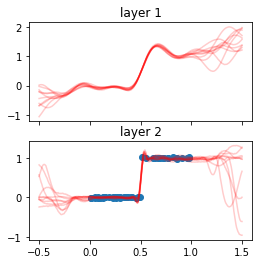

In [12]:
def plot_layers(model, X, Y):
    L = len(model.layers)
    f, axs = plt.subplots(L, 1, figsize=(4, 2*L), sharex=True)
    if L == 1:
        axs = [axs, ]

    samples, _, _ = model.predict_all_layers_full_cov(Xs, 10)
    for s, ax in zip(samples, axs):
        ax.plot(Xs.flatten(), s[:, :, 0].T, color='r', alpha=0.2)

    axs[-1].scatter(X, Y)
    for l in range(L):
        axs[l].set_title('layer {}'.format(l+1))
    plt.show()

plot_layers(m_dgp_2, X, Y)

Here's the three layer version

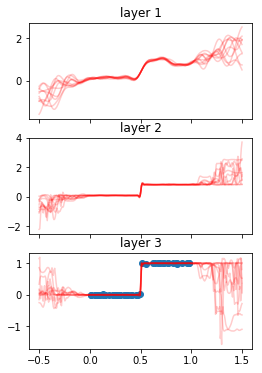

In [13]:
m_dgp_3 = make_DGP(3)
AdamOptimizer(0.01).minimize(m_dgp_3, maxiter=1000)
plot_layers(m_dgp_3, X, Y)